# Random Forests vs. Neural Networks

## Comparing two common ML methods

This simple example compares the speed, accuracy, and extrapolation capabilities of a standard random forest (n = 100 trees) created using the Python package SKlearn to an ensemble (N = 30) of Dense Feedforward Neural Networks created using the Python package Keras and run using Tensorflow on a single graphics processing unit (GPU).

### Sample Data: Environment Canada Burns Bog Climate Station

* Our goal is to estimate Relative Humidity (RH) from Air Temperature (Ta) and Dew Point Temperature (Tdew).

(2, 2500)


Text(0, 0.5, 'Relative Humidity %')

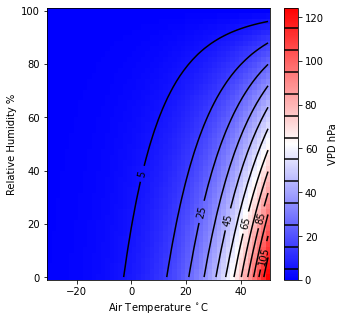

In [61]:
## Import some standard packages

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def Calc_VPD(TA, RH):
    # Calculate vapour pressure (hPa)
    # From TA (in celsius) and RH %
    ea_H = 0.61365*np.exp((17.502*TA)/(240.97+TA))

    e_H = RH*ea_H/100

    VPD = ea_H - e_H

    # Limit precision
    VPD = np.round(VPD*10,5)
    return (VPD)

def Create_Grid(x1,x2,func=None):  
    grid_x1,grid_x2 = np.meshgrid(x1,x2)
    flat_X=np.array([grid_x1.flatten(),grid_x2.flatten()])
    print(flat_X.shape)
    if func != None:
        flat_Y = func(flat_X[0],flat_X[1])
        grid_y = flat_Y.reshape(grid_x1.shape)
    else:
        grid_y = None
    return(flat_X,grid_x1,grid_x2,grid_y)


def Contour_Plot(ax,grid_x1,grid_x2,grid_y,cmap='bwr',units='',bins=None):
    if bins is None:
        bins = np.linspace(grid_y.min(),grid_y.max())
    
    def fmt(x):
        s = f"{x:.1f}"
        if s.endswith("0"):
            s = f"{x:.0f}"
        return rf"{s}"

    c = ax.pcolormesh(
        grid_x1,grid_x2,grid_y,
        cmap=cmap)
    cb = fig.colorbar(c)

    CS = ax.contour(
        grid_x1,grid_x2,grid_y,
        levels=bins,
        colors='k',
        )
    ax.clabel(CS, CS.levels[::2], inline=True, fmt=fmt, fontsize=10)

    ax = cb.ax
    xmin, xmax = ax.get_xlim()
    ax.hlines(bins, xmin, xmax, colors=['black'])
    ax.set_ylabel(units)


range_TA_RH,grid_TA,grid_RH,grid_VPD = Create_Grid(
    np.linspace(-30,50),# Define a TA range (in C)
    np.linspace(0,100), # Possible RH values
    Calc_VPD
    )

bins = np.arange(5,grid_VPD.max(),10)
unit = 'hPa'
fig,ax=plt.subplots(1,figsize=(5,5))
Contour_Plot(ax,grid_TA,grid_RH,grid_VPD,units='VPD hPa',bins=bins)
ax.set_xlabel('Air Temperature $^\circ$C')
ax.set_ylabel('Relative Humidity %')
ax.set_title('Vapor Pressure Deficit (VPD)')

In [42]:


# Read/parse the input data
root_url = "Data/DELTA BURNS BOG.csv"
Data = pd.read_csv(root_url, parse_dates=['LOCAL_DATE'], low_memory=False)
Data = Data.set_index('LOCAL_DATE')
Data = (Data[['TEMP','RELATIVE_HUMIDITY']].dropna())
Data['VPD'] = Calc_VPD(Data['TEMP'],Data['RELATIVE_HUMIDITY'])
Data.describe().round(2)

,TEMP,RELATIVE_HUMIDITY,VPD
count,66513.00,66513.00,66513.00
mean,10.39,82.67,3.16
std,7.07,18.07,4.59
min,-15.10,13.00,0.00
25%,5.80,70.00,0.23
50%,10.20,90.00,1.13
75%,14.90,98.00,4.29
max,37.50,100.00,46.40


# Mask the input data

RH is a non-linear function of Ta and Tdew
* To investigate the extrapolation capability of the models, we are going to mask out data where RH > 95%.
    * We can see how well the models perform on the training dat (RH < 95%) and the masked data (RH > 95%).


In [33]:
X_vars = ['TEMP', 'RELATIVE_HUMIDITY']
X_alias = ['Air Temp','RH %']
Y_var = 'VPD'
Y_alias = 'VPD'

X_full = Data[X_vars].values
Y_full = Data[Y_var].values.reshape(-1,1)



x_mask = Data.loc[Data[Y_var]>100,X_vars].values
x = Data.loc[Data[Y_var]<=100,X_vars].values

y_mask = Data.loc[Data[Y_var]>100,Y_var].values
y = Data.loc[Data[Y_var]<=100,Y_var].values

print('Training Samples: ',y.shape)
print('Masked Samples: ',y_mask.shape)

Training Samples:  (66513,)
Masked Samples:  (0,)


# Random Forest

The random forest is very simple to set up and it can be trained very fast with minimal computational overhead.  This makes them desireable for many applications (e.g., landscape classification).

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Set 10% of training data aside for testing
# The RF model bootstraps the training data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42)

# Time the run
T1 = time.time()
# Initialize the model
RF = RandomForestRegressor()
# Fit the model
RF.fit(x_train, y_train)
T2 = time.time()
print('Training Time: ', np.round(T2 - T1,2),' Seconds')


Training Time:  3.9  Seconds


### Validation

The RF performs very well on within the domain of the training data (RH < 95%), but the test data highlights extrapolation issues that RF models face.
* The model is incapable of making a projection beyond the bounds of the data it was trained on, which can result in erroneous estimates
    * This could be particularly problematic in high dimensional feature space where we cannot adequately visualize the domain of a training dataset

Validation Metrics: testing Data 
r2 =  1.0 
RMSE =  0.0



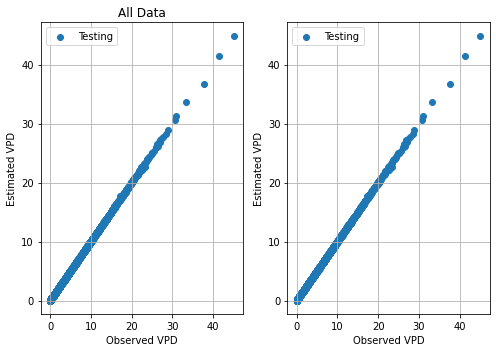

In [35]:
test = RF.predict(x_test)
# Mask = RF.predict(x_mask)

fig,axes=plt.subplots(1,2,figsize=(7,5))
for ax in axes:
    # ax.scatter(y_mask,Mask,label='Masked')
    ax.scatter(y_test,test,label='Testing')
    # ax.plot([0,100],[0,100],color='k',label='1:1')
    ax.set_ylabel('Estimated '+Y_alias)
    ax.set_xlabel('Observed '+Y_alias)
    ax.grid()
    ax.legend()

axes[0].set_title('All Data')
# axes[0].set_xlim(0,101)
# axes[0].set_ylim(0,101)
# axes[1].set_title('Masked Data')
# axes[1].set_xlim(85,101)
# axes[1].set_ylim(85,101)
plt.tight_layout()


R2 = metrics.r2_score(y_test,test)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_test,test)
print('Validation Metrics: testing Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

print()

# R2 = metrics.r2_score(y_mask,Mask)
# if R2 < 0:
#     R2 = 0.0
# RMSE = metrics.mean_squared_error(y_mask,Mask)
# print('Validation Metrics: Masked Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))


# Inspecting the model

With RF models, we are limited what we can see from the model.  We can easily plot the feature importance, which is helpful in determining which variables the models find important.  We can also inspect individual trees to see the decision flow - but comparing each tree is difficult and in a typical RF trees are not limited in depth, so its impossible/unhelpful to view the full tree.

* A decision tree is just a complex series of binary yes/no decisions.  Its not attempting to approximate a continuous function, rather its creating a complex piecewise function uniquely fit to a dataset.  

* Random forest area  powerful tool for classification - they work great on qualitative data.  However, I don't think they are as useful for quantitative data.

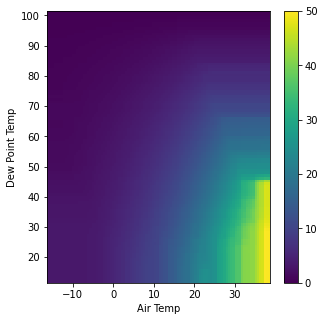

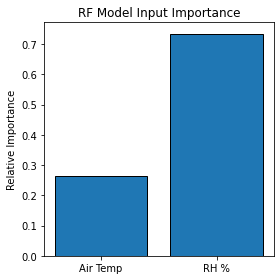

In [36]:
from sklearn import tree
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig,ax=plt.subplots(figsize=(5,5))#,dpi=200)
a = DecisionBoundaryDisplay.from_estimator(
        RF,
        x_train,
        plot_method='pcolormesh',
        response_method="predict",
        ax=ax,
        xlabel='Air Temp',
        ylabel='Dew Point Temp',
    )
# print(a.response)
norm = Normalize(vmin=0, vmax=50, clip=False)
fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax)


# Inspect the "feature importance"
# The relative weight of the input data in the model
fig,ax=plt.subplots(figsize=(4,4))
ax.bar(X_alias,RF.feature_importances_,edgecolor='k')
ax.set_ylabel('Relative Importance')
ax.set_title('RF Model Input Importance')
plt.tight_layout()


# fig,ax = plt.subplots(1,figsize=(8,8))#,dpi=400)
# tree.plot_tree(RF.estimators_[0],max_depth=5,ax=ax,fontsize=5)
# plt.show()

# fig,ax = plt.subplots(2,3,figsize=(10,10))#,dpi=400)
# i = 0
# for AX in ax:
#     for a in AX:
#         tree.plot_tree(RF.estimators_[i],max_depth=2,ax=a,fontsize=5)
#         i += 1
# plt.show()

# Neural Network

* The NN ensemble is not as simple to set up - it requires the user to install more packages (e.g., Tensorflow) which can be tricky, and defining the model takes more time/consideration.

* Training is also considerably slower
    * This model is being run on a GPU which helps speed things up.  It can be run on a system without a suitable GPD, but processing on a CPU alone is **much slower**

* One NN is prone to over/under fitting, but an ensemble of NNs is more stable.  This is similar to the distinction between a random forest and a decision tree.
    * Ensembling increases accuracy but also increases training time.  This example uses an ensemble of n=30 randomly initialized networks trained on 30 randomly split iterations of the training data.


In [37]:
from tensorflow import keras
from keras.models import model_from_json
import json
import os
from os import walk

def clean_dir():
    for (_, _, filenames) in walk('temp_files'):
        for f in filenames:
            if f != '.gitignore':
                os.remove('temp_files/'+f)

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    dense1 = keras.layers.Dense(
        64,
        activation='relu',
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros"
    )(input_layer)
    output_layer = keras.layers.Dense(1)(dense1)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)


Training_Time = []
T0 = time.time()

N = 10

clean_dir()

for i in range(0,N):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.1, random_state=N
        )
    if i == 0:
        Test_sets_x = [x_test]
        Test_sets_y = [y_test]
    else:
        Test_sets_x.append(x_test)
        Test_sets_y.append(y_test)

    T1 = time.time()
    model = make_model(input_shape=x_train.shape[1:])

    epochs = 250
    batch_size = 32

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            "temp_files/model_weights"+str(i)+".h5", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=0),
    ]

    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
    )

    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=0,
    )

    T2 = time.time()
    Training_Time.append(round(T2 - T1,2))
    print('Network #'+str(i)+' Training Complete')
    # print('')

    if i == 0:
        model_json = model.to_json()
        with open("temp_files/model_architecture.json", "w") as json_file:
            json_file.write(model_json)
    
Training_Time = np.array(Training_Time)
print('\nFull Training Time: ', np.round(Training_Time.sum()/60,2),' Minutes')
print('\nTime: Per Model', np.round(Training_Time.mean(),2),' Seconds')

print('\nModel Architecture')

model.summary()

Network #0 Training Complete
Network #1 Training Complete
Network #2 Training Complete
Network #3 Training Complete
Network #4 Training Complete
Network #5 Training Complete
Network #6 Training Complete
Network #7 Training Complete
Network #8 Training Complete
Network #9 Training Complete

Full Training Time:  4.07  Minutes

Time: Per Model 24.42  Seconds

Model Architecture
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


# Validation

* The model is capable of extrapolating and making a reasonable guess at RH above 95% from Ta and Tdew without having been exposed to those conditions.

Prediction Time:  2.61  Seconds
Validation Metrics: testing Data 
r2 =  0.9981 
RMSE =  0.04



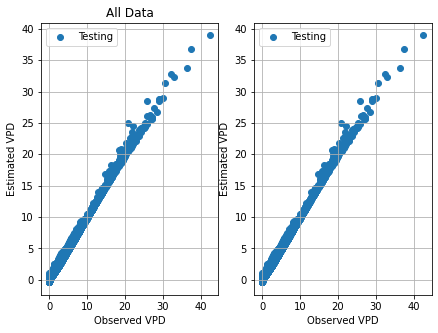

In [38]:
test = []
# Mask = []
grid_xx,grid_yy = np.meshgrid(np.linspace(Data['TEMP'].min(),Data['TEMP'].max()),np.linspace(Data['RELATIVE_HUMIDITY'].min(),Data['RELATIVE_HUMIDITY'].max()))
Grid_Data=np.array([grid_xx.flatten(),grid_yy.flatten()])
# Grid_Data = Grid.reshape(2,-1).T
Grid_Precit = []

T1 = time.time()

with open("temp_files/model_architecture.json", 'r') as json_file:
    architecture = json.load(json_file)
    loaded_model = model_from_json(json.dumps(architecture))

for i in range(N):
    loaded_model.load_weights("temp_files/model_weights"+str(i)+".h5")
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')
    
    test.append(loaded_model.predict(x_test))
    # Mask.append(loaded_model.predict(x_mask))
    Grid_Precit.append(loaded_model.predict(Grid_Data.T).T.reshape(50,50))

T2 = time.time()

print('Prediction Time: ', np.round(T2 - T1,2),' Seconds')

test = np.array(test).mean(axis=0)
# Mask = np.array(Mask).mean(axis=0)
Grid_Precit = np.array(Grid_Precit).mean(axis=0)

fig,axes=plt.subplots(1,2,figsize=(7,5))
for ax in axes:
    # ax.scatter(y_mask,Mask,label='Masked')
    ax.scatter(y_test,test,label='Testing')
    # ax.plot([0,100],[0,100],color='k',label='1:1')
    ax.set_ylabel('Estimated '+Y_alias)
    ax.set_xlabel('Observed '+Y_alias)
    ax.grid()
    ax.legend()

axes[0].set_title('All Data')
# axes[0].set_xlim(0,101)
# axes[0].set_ylim(0,101)
# axes[1].set_title('Masked Data')
# axes[1].set_xlim(85,101)
# axes[1].set_ylim(85,101)
# plt.tight_layout()


R2 = metrics.r2_score(y_test,test)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_test,test)
print('Validation Metrics: testing Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

print()

# R2 = metrics.r2_score(y_mask,Mask)
# if R2 < 0:
#     R2 = 0.0
# RMSE = metrics.mean_squared_error(y_mask,Mask)
# print('Validation Metrics: Masked Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))


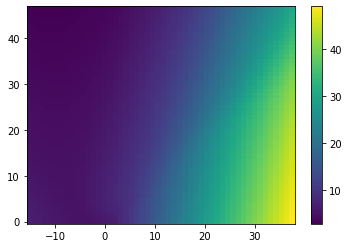

In [39]:
plt.figure()
plt.pcolormesh(grid_xx,grid_yy,Grid_Precit)
plt.colorbar()

,count,mean,std,min,25%,50%,75%,max
dVPD_dTEMP,66513.0,1.081,0.297,-0.210,1.164,1.201,1.215,1.222
dVPD_dRELATIVE_HUMIDITY,66513.0,-0.077,0.010,-0.108,-0.086,-0.084,-0.066,-0.061
dVPD_dTEMP_se,66513.0,0.047,0.017,0.032,0.034,0.035,0.061,0.101
dVPD_dRELATIVE_HUMIDITY_se,66513.0,0.004,0.001,0.004,0.004,0.004,0.005,0.011
VPD_estimated,66513.0,3.124,4.585,-0.466,0.215,1.111,4.200,41.278
VPD,66513.0,3.165,4.587,-0.000,0.230,1.134,4.291,46.396
TEMP,66513.0,10.390,7.067,-15.100,5.800,10.200,14.900,37.500
RELATIVE_HUMIDITY,66513.0,82.666,18.073,13.000,70.000,90.000,98.000,100.000


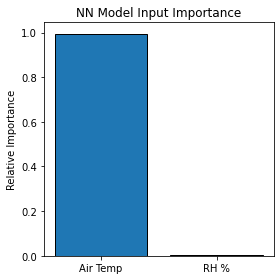

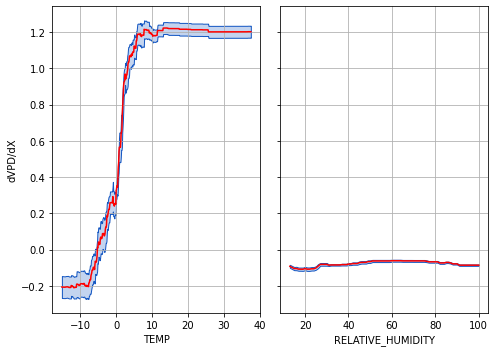

In [40]:

def Get_Weights(N):
    with open("temp_files/model_architecture.json", 'r') as json_file:
        architecture = json.load(json_file)
        # print(architecture)
        loaded_model = model_from_json(json.dumps(architecture))

    # Input layer
    W_i = []
    # Transposed Input layer
    W_i_T = []
    # Dense Input Layer
    W_d_i = []
    # Dense Output Layer
    W_d_o = []
    # Transposed Dense Output Layer
    W_d_o_T = []
    # Output Layer
    W_o = []

    for i in range(N):
        loaded_model.load_weights("temp_files/model_weights"+str(i)+".h5")
        W = loaded_model.get_weights()
        W_i.append(W[0])
        W_i_T.append(W[0].T)
        W_d_i.append(W[1])
        W_d_o.append(W[2])
        W_d_o_T.append(W[2].T)
        W_o.append(W[3])
    W_i = np.array(W_i)
    W_i_T = np.array(W_i_T)
    W_d_i = np.array(W_d_i)
    W_d_o = np.array(W_d_o)
    W_d_o_T = np.array(W_d_o_T)
    W_o = np.array(W_o)

    return(W_i,W_i_T,W_d_i,W_d_o,W_d_o_T,W_o)        

def get_Derivatives(N,X,y):
    W_i,W_i_T,W_d_i,W_d_o,W_d_o_T,W_o = Get_Weights(N)
    Op = []
    for i in range(X.shape[0]):
        Ip = X[i]
        H1 = (Ip*W_i_T).sum(axis=-1)+W_d_i
        # First derivative of the relu function
        # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
        H1 = np.maximum(H1,np.zeros(H1.shape))
        H2 = (H1*W_d_o_T).sum(axis=-1)+W_o
        Op.append(H2.diagonal())
    Estimates = np.array(Op)
    Cons = []
    Derivs = []
    for i in range(X.shape[1]):
        dj=[]
        for j in range(y.shape[0]):
            target = y[j]
            Xj = X[j][i]
            if np.isnan(target)==False:
                H1 = ((Xj*W_i[:,i,:]))+W_d_i
                AD = np.maximum(H1,np.zeros(H1.shape))
                AD[AD>0]=1
                Sum = np.array([AD[:,h]*W_d_o[:,h,0]*W_i[:,i,h] for h in range(W_d_o.shape[1])]).sum(axis=0)
                Sj = 1
                dj.append(Sj*Sum)
        dji = np.array(dj)
        Derivs.append(dji)
        Cons.append(np.sum(dji**2,axis=0))
    Derivs = np.array(Derivs)
    Cons = np.array(Cons)
    RIs = Cons/Cons.sum(axis=0)
    return(RIs,Derivs,Estimates)
    
Relative_Importance,Derivatives,Estimates = get_Derivatives(N, X_full, Y_full)

RI_mean = Relative_Importance.mean(axis=1)
RI_se = Relative_Importance.std(axis=1)/Relative_Importance.shape[1]**.5

fig,ax=plt.subplots(figsize=(4,4))
ax.bar(X_alias,RI_mean,yerr=RI_se,edgecolor='k')
ax.set_ylabel('Relative Importance')
ax.set_title('NN Model Input Importance')
plt.tight_layout()

Estimates_mean = Estimates.mean(axis=1)

Model_Derivatives = pd.DataFrame(Derivatives.mean(axis=-1).T, columns = ['dVPD_d'+x for x in X_vars])
Model_Derivatives = Model_Derivatives.join(
    pd.DataFrame(Derivatives.std(axis=-1).T/Derivatives.shape[-1]**.5, columns = ['dVPD_d'+x+'_se' for x in X_vars])
)
Model_Derivatives['VPD_estimated'] = Estimates_mean
Model_Derivatives['VPD'] = Y_full
Model_Derivatives[X_vars] = X_full

def Plot_Derivs(Derivs,X,dy,ax):
    D = Derivs[[X,dy,dy+'_se']].sort_values(by=X)
    ax.fill_between(D[X],D[dy]-D[dy+'_se'],D[dy]+D[dy+'_se'],
                    facecolor='#1356c240',edgecolor='#1356c2')
    ax.plot(D[X],D[dy],color='r')
    ax.grid()
    ax.set_xlabel(X)


fig,ax = plt.subplots(1,2,figsize = (7,5),sharey=True)
Plot_Derivs(Model_Derivatives,'TEMP','dVPD_dTEMP',ax[0])
Plot_Derivs(Model_Derivatives,'RELATIVE_HUMIDITY','dVPD_dRELATIVE_HUMIDITY',ax[1])
ax[0].set_ylabel('dVPD/dX')

plt.tight_layout()


Model_Derivatives.describe().T.round(3)
